In [2]:
# For plots
import matplotlib.pyplot as plt

from astropy.wcs import WCS

import numpy as np

from astropy.coordinates import SkyCoord
import astropy.units as u

import os
import sys
from astropy.io import fits

# Get the current working directory
curr_folder = os.getcwd()

# Find the index of 'notebooks' in the current path
notebooks_index = curr_folder.rfind('notebooks')

# Check if 'notebooks' is found in the path
if notebooks_index != -1:
    # Set the directory to the parent of 'notebooks'
    src_path = os.path.dirname(curr_folder[:notebooks_index])
    os.chdir(src_path)  # Change the current working directory to the source path
    sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports
    
# Lombardi et al
# the catalogue name in VizieR
CATALOGUE_LOMBARDI = "J/A+A/566/A45"

CATALOGUE_MEGEATH = "J/AJ/144/192"

## Column Density & Mass Maps Derivation

<>:135: SyntaxWarning: invalid escape sequence '\o'
<>:135: SyntaxWarning: invalid escape sequence '\o'
C:\Users\User\AppData\Local\Temp\ipykernel_19876\3782709389.py:135: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('Mass [M$_\odot$/cm$^2$]', fontsize=13)


Filename: c:\Users\User\Desktop\MA_Astro\Master Thesis\Lombardi\planck_herschel.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3444, 2492, 7)   float32   


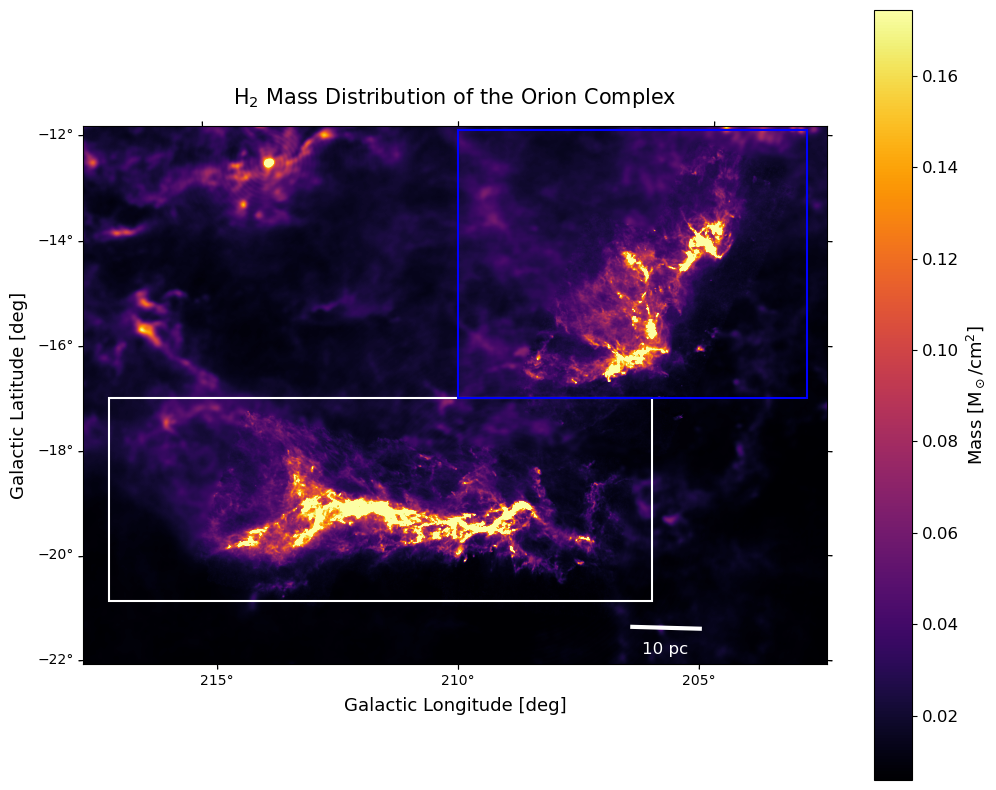

235938.58566051646


In [3]:
import matplotlib.patches as patches

def read_fits(filepath, print_header):
    # Check if the FITS file exists
    if not os.path.isfile(filepath):
        print(f"File not found: {filepath}")
    else:
        try:
            # Open the FITS file
            with fits.open(filepath) as hdul:
                # Print a summary of the HDUs (Header Data Units)
                hdul.info()

                # Access the primary HDU data (usually image data)
                primary_hdu = hdul[0].data
                
                # Access the header of the primary HDU
                header = hdul[0].header
                
                if print_header:
                    print("Header Information (without blank spaces):")
                    print("-" * 60)  # Separator line
                    for key in header.keys():
                        value = header[key]
                        comment = header.comments[key]
                        # Remove extra spaces from key, value, and comment
                        clean_key = key.strip()
                        clean_value = str(value).strip()
                        clean_comment = comment.strip()
                        print(f"{clean_key}={clean_value}#{clean_comment}")  # Format output without spaces

        except Exception as e:
            print(f"An error occurred while opening the FITS file: {e}")
    
    return primary_hdu, header

# Construct the path to the FITS file
planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")
maps_fits_file = os.path.join(curr_folder, "Lombardi", "maps.fits.gz")

hdu_herschel_fits_data, hdu_herschel_fits_header = read_fits(planck_herschel_fits_file, print_header=False)

# Constructt WCS and image data
wcs = WCS(hdu_herschel_fits_header)

image_data = hdu_herschel_fits_data[0]

# Replace NaNs and Infs with some valid value, e.g., zero or the median
tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

# Step 1: Define constants
# TO-DO: differentiate between Orion A and B 

# Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
# Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

# Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
l_min_A, l_max_A = 206, 217
b_min_A, b_max_A = -21, -17

min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

gamma_orion_A = 2640  # mag
delta_orion_A = 0.012  # mag, Offset for Orion A

A_k = gamma_orion_A * tau + delta_orion_A

A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

l_min_B, l_max_B = 203, 210
b_min_B, b_max_B = -17, -12

min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

gamma_orion_B = 3460  # mag
delta_orion_B = -0.001  # mag, Offset for Orion B

A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

# A_k to A_V
A_V = A_k/0.112

# N(H2)
N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

pixel_scale = 0.00417
distance = 420
radians = 180/np.pi #conversion factor: rad in deg
rad_per_px = pixel_scale/radians
pc_per_px = np.sin(rad_per_px)*distance
pc2_per_px = pc_per_px**2
cm_per_pc = 3.086*10**18
cm2_per_px = pc2_per_px * (cm_per_pc ** 2) 

D = 412

m_p = 1.67e-27 # mass of proton (kg)

M_H2 = np.array(N_H2, dtype=np.float64)*2.8*m_p/(1.98e30)

# M_H2 = M_H2*area # check here!
M_H2 = M_H2 * cm2_per_px

# Assuming M_H2_clean is already defined
M_H2_clean = np.nan_to_num(M_H2, nan=0.0, posinf=0.0, neginf=0.0)

# Masking out negative values
M_H2_clean_positive = np.where(M_H2_clean > 0, M_H2_clean, 0)

min_value = np.percentile(M_H2_clean_positive, 1)  # 2nd percentile
max_value = np.percentile(M_H2_clean_positive, 99)  # 98th percentile

plt.figure(figsize=(12, 10))
ax = plt.subplot(111, projection=wcs[0])

# Plot the map with imshow
sp = ax.imshow(M_H2_clean_positive, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap = 'inferno') # from the perceptually uniform sequential colormaps
ax.set_title("H$_2$ Mass Distribution of the Orion Complex", fontsize=15, pad=16)

# Add grid and colorbar
ax.set_xlabel("Galactic Longitude [deg]", fontsize=13)
ax.set_ylabel("Galactic Latitude [deg]", fontsize=13)

fig = plt.gcf()  # Get the current figure
cbar = fig.colorbar(sp)  # Label the colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Mass [M$_\odot$/cm$^2$]', fontsize=13)

# Define the rectangles for Orion A and B
# Rectangle for Orion A
width_A = max_pixel_A[0] - min_pixel_A[0]
height_A = max_pixel_A[1] - min_pixel_A[1]
rect_A = patches.Rectangle((min_pixel_A[0], min_pixel_A[1]), width_A, height_A, 
                           linewidth=1.5, edgecolor='white', facecolor='none')
ax.add_patch(rect_A)

# Rectangle for Orion B
width_B = max_pixel_B[0] - min_pixel_B[0]
height_B = max_pixel_B[1] - min_pixel_B[1]
rect_B = patches.Rectangle((min_pixel_B[0], min_pixel_B[1]), width_B, height_B, 
                           linewidth=1.5, edgecolor='blue', facecolor='none')
ax.add_patch(rect_B)

# scale_bar
# Compute the angle corresponding to 10 pc at the distance of the galactic center
gc_distance = 412 * u.pc
scalebar_length = 10 * u.pc
scalebar_angle = (scalebar_length / gc_distance).to(
    u.deg, equivalencies=u.dimensionless_angles()
)

# Define values with units
y = -21.5 * u.deg
xmin = 205 * u.deg
xmax = (205 * u.deg + scalebar_angle)

# Convert to degrees as floats
y_deg = y.to(u.deg).value
xmin_deg = xmin.to(u.deg).value
xmax_deg = xmax.to(u.deg).value

# Plot the line without units in hlines
ax.plot([xmin_deg, xmax_deg], [y_deg, y_deg], transform=ax.get_transform('world'), color='white', linewidth=3)
ax.text((xmin_deg + xmax_deg) / 2, y_deg - 0.5, "10 pc", transform=ax.get_transform('world'), color='white', ha='center', fontsize=12)

plt.show()
print(np.sum(M_H2_clean_positive))

### Orion A

Total mass above threshold (8.41e-02 M_sun/cm²): 3.34e+04 M_sun


<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
C:\Users\User\AppData\Local\Temp\ipykernel_19876\3447121559.py:39: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('Mass [M$_\odot$/cm$^2$]', fontsize=13)


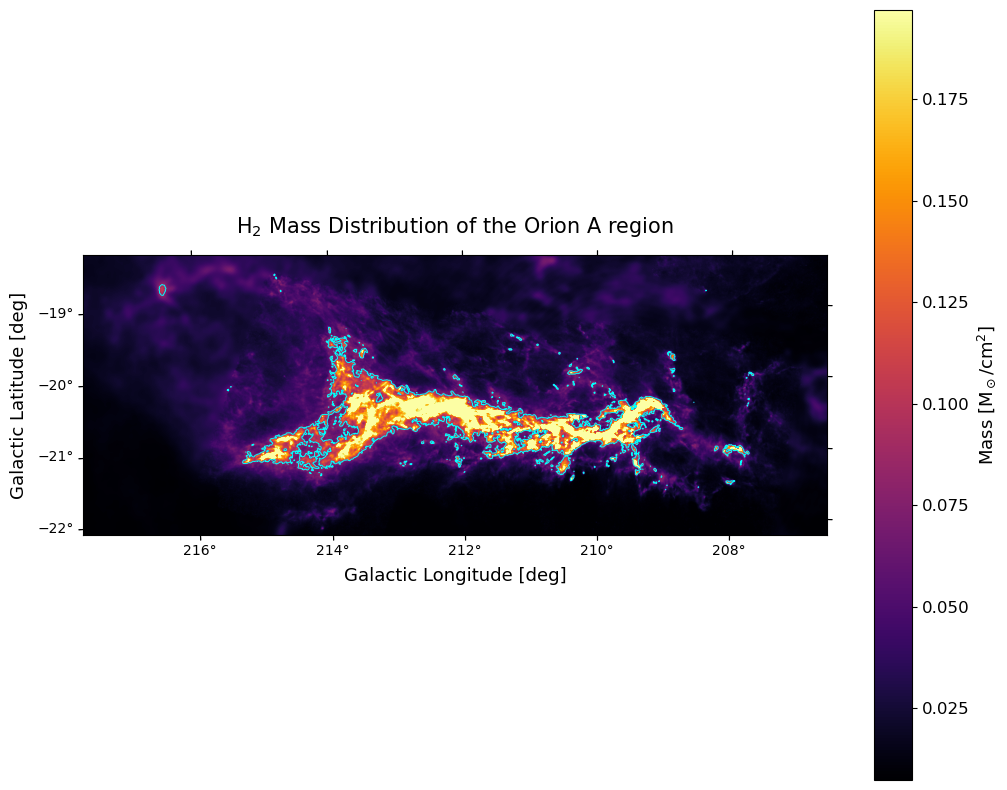

In [4]:
M_H2_OA = M_H2_clean_positive[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]

# Define parameters
high_density_gas = 4*10**21  # Threshold for high-density gas in cm^-2
mass_threshold = cm2_per_px * high_density_gas * 2.8 * m_p / (1.98e30)  # Threshold in M_sun/cm^2

# Mask for values above the mass threshold
mass_mask = M_H2_OA >= mass_threshold

# Calculate the total mass above the threshold
total_mass_above_threshold = np.sum(M_H2_OA[mass_mask])

# Print the total mass
print(f"Total mass above threshold ({mass_threshold:.2e} M_sun/cm²): {total_mass_above_threshold:.2e} M_sun")

# Plotting
plt.figure(figsize=(12, 10))
ax = plt.subplot(111, projection=wcs[0])

# Define color limits based on percentiles
min_value = np.percentile(M_H2_OA, 2)  # 2nd percentile
max_value = np.percentile(M_H2_OA, 98)  # 98th percentile

# Plot the map
sp = ax.imshow(M_H2_OA, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap='inferno')
ax.set_title("H$_2$ Mass Distribution of the Orion A region", fontsize=15, pad=16)

ax.set_xlabel("Galactic Longitude [deg]", fontsize=13)
ax.set_ylabel("Galactic Latitude [deg]", fontsize=13)

# Overlay contour at the mass threshold level

ax.contour(M_H2_OA, levels=[mass_threshold], colors='cyan', linewidths=0.7, origin='lower')

# Add grid and colorbar
fig = plt.gcf()  # Get the current figure
cbar = fig.colorbar(sp)  # Label the colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Mass [M$_\odot$/cm$^2$]', fontsize=13)

plt.show()

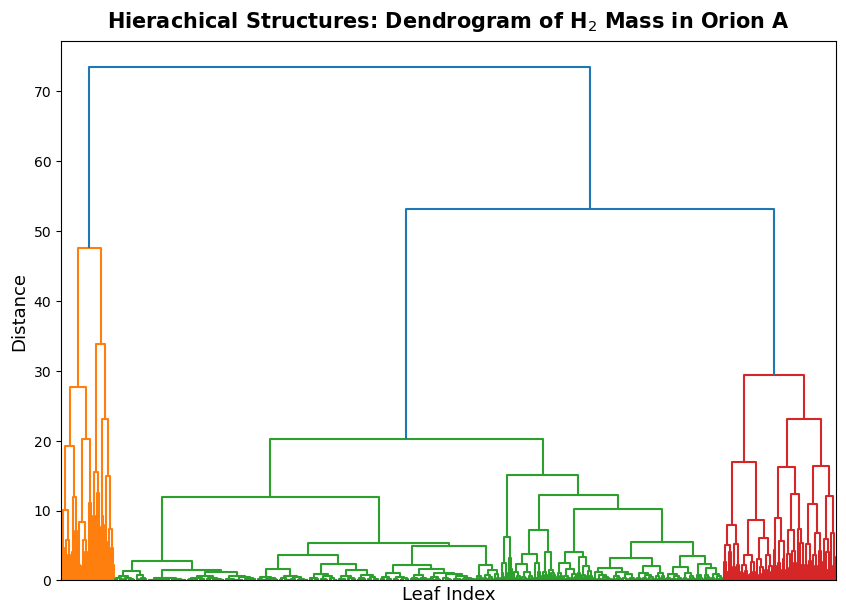

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

# Perform hierarchical clustering
linkage_matrix = sch.linkage(M_H2_OA, method='ward')

# Create the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True)  # Remove default labels

# Customize the plot
plt.title("Hierachical Structures: Dendrogram of H$_2$ Mass in Orion A", fontweight="bold", fontsize=15, pad=10)
plt.xlabel("Leaf Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)

# Set custom x-ticks: display fewer ticks by setting a stride
num_ticks = 0  # Number of ticks you want to show
xtick_positions = np.linspace(0, len(linkage_matrix), num_ticks, dtype=int)
plt.xticks(xtick_positions, labels=xtick_positions, fontsize=10)  # Set custom tick labels

plt.show()


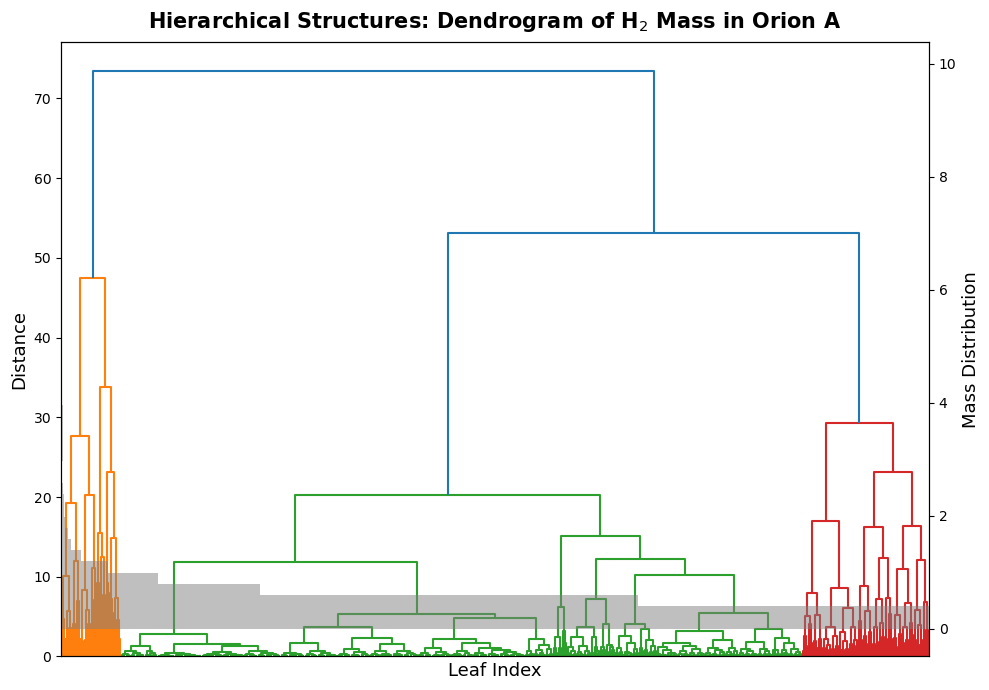

In [68]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

# Perform hierarchical clustering
linkage_matrix = sch.linkage(M_H2_OA, method='ward')

# Create a figure and an axis for the dendrogram
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True, ax=ax1)
ax1.set_title("Hierarchical Structures: Dendrogram of H$_2$ Mass in Orion A", fontweight="bold", fontsize=15, pad=10)
ax1.set_xlabel("Leaf Index", fontsize=13)
ax1.set_ylabel("Distance", fontsize=13)

# Create a secondary y-axis to represent the mass distribution
ax2 = ax1.twinx()

# Flatten the M_H2_OA array to use for mass distribution
mass_data = M_H2_OA.flatten()

# Plot a histogram or density plot of the mass distribution
ax2.hist(mass_data, bins=50, alpha=0.5, color='gray', orientation='horizontal')
ax2.set_ylabel("Mass Distribution", fontsize=13)
# ax2.set_xlim(0, np.max(mass_data) * 1.1)  # Adjust limits for better visibility

# Adjust layout for clarity
fig.tight_layout()

plt.show()

In [53]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming you've already created the linkage_matrix
ddata = dendrogram(linkage_matrix, no_plot=True)

# Function to count branches above a given height
def count_branches(ddata, height):
    return sum(1 for d in ddata['dcoord'] if max(d) > height)

# Generate a range of heights to evaluate
heights = np.linspace(min(min(d) for d in ddata['dcoord']), max(max(d) for d in ddata['dcoord']), 50)

# Count branches at each height
branch_counts = [count_branches(ddata, h) for h in heights]

print(branch_counts)
print(heights)

branch_counts[1:]/heights[1:]

np.mean(branch_counts[1:]/(heights[1:]))

[99, 60, 34, 25, 21, 13, 12, 11, 9, 8, 7, 7, 7, 6, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0.         0.07487634 0.14975268 0.22462902 0.29950536 0.3743817
 0.44925804 0.52413438 0.59901073 0.67388707 0.74876341 0.82363975
 0.89851609 0.97339243 1.04826877 1.12314511 1.19802145 1.27289779
 1.34777413 1.42265047 1.49752681 1.57240315 1.64727949 1.72215584
 1.79703218 1.87190852 1.94678486 2.0216612  2.09653754 2.17141388
 2.24629022 2.32116656 2.3960429  2.47091924 2.54579558 2.62067192
 2.69554826 2.7704246  2.84530095 2.92017729 2.99505363 3.06992997
 3.14480631 3.21968265 3.29455899 3.36943533 3.44431167 3.51918801
 3.59406435 3.66894069]


28.437400158822093

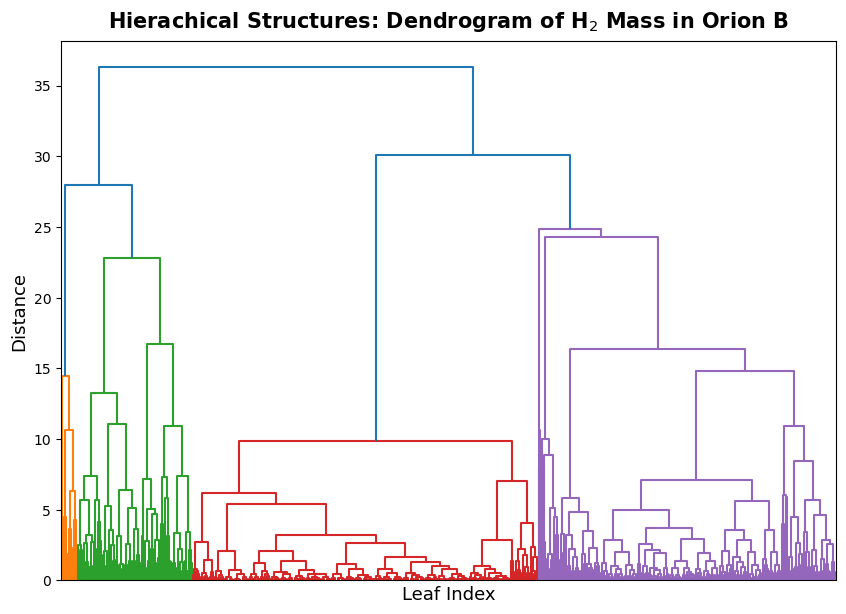

In [8]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

M_H2_OB = M_H2_clean_positive[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

# Perform hierarchical clustering
linkage_matrix = sch.linkage(M_H2_OB, method='ward')

# Create the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True)  # Remove default labels

# Customize the plot
plt.title("Hierachical Structures: Dendrogram of H$_2$ Mass in Orion B", fontweight="bold", fontsize=15, pad=10)
plt.xlabel("Leaf Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)

# Set custom x-ticks: display fewer ticks by setting a stride
num_ticks = 0  # Number of ticks you want to show
xtick_positions = np.linspace(0, len(linkage_matrix), num_ticks, dtype=int)
plt.xticks(xtick_positions, labels=xtick_positions, fontsize=10)  # Set custom tick labels

# Define explanatory text
textstr_1 = '\n'.join((
    "Each leaf is an individual data point",
    "in the mass dataset",
))

textstr_2 = '\n'.join((
    "The height of the lines indicates",
    "the similarity between clusters."
))
"""
# Define properties of the text box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)

# Add the first text box
plt.gca().text(0.055, 0.92, textstr_1, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=props)
# Add the second text box
plt.gca().text(0.055, 0.83, textstr_2, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=props)

"""
plt.show()


ImportError: cannot import name 'Iterable' from 'collections' (c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\collections\__init__.py)